In [2]:
# Liam Bonifield
# CMPE255
# SJSU ID: 017512898

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score


In [3]:
df = pd.read_csv("household_power_consumption.txt", sep = ';', na_values = '?')
print(df.shape)

(2075259, 9)


In [4]:
emptyRows = df[df["Sub_metering_3"].isna()]
print(emptyRows)

               Date      Time  Global_active_power  Global_reactive_power  \
6839     21/12/2006  11:23:00                  NaN                    NaN   
6840     21/12/2006  11:24:00                  NaN                    NaN   
19724    30/12/2006  10:08:00                  NaN                    NaN   
19725    30/12/2006  10:09:00                  NaN                    NaN   
41832     14/1/2007  18:36:00                  NaN                    NaN   
...             ...       ...                  ...                    ...   
1990185   28/9/2010  19:09:00                  NaN                    NaN   
1990186   28/9/2010  19:10:00                  NaN                    NaN   
1990187   28/9/2010  19:11:00                  NaN                    NaN   
1990188   28/9/2010  19:12:00                  NaN                    NaN   
2027411  24/10/2010  15:35:00                  NaN                    NaN   

         Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  \
6839 

In [5]:
scrubbed = df.dropna()
print(scrubbed.shape)
print("Rows removed that contained '?': ", df.shape[0] - scrubbed.shape[0])

(2049280, 9)
Rows removed that contained '?':  25979


(2049280, 7)


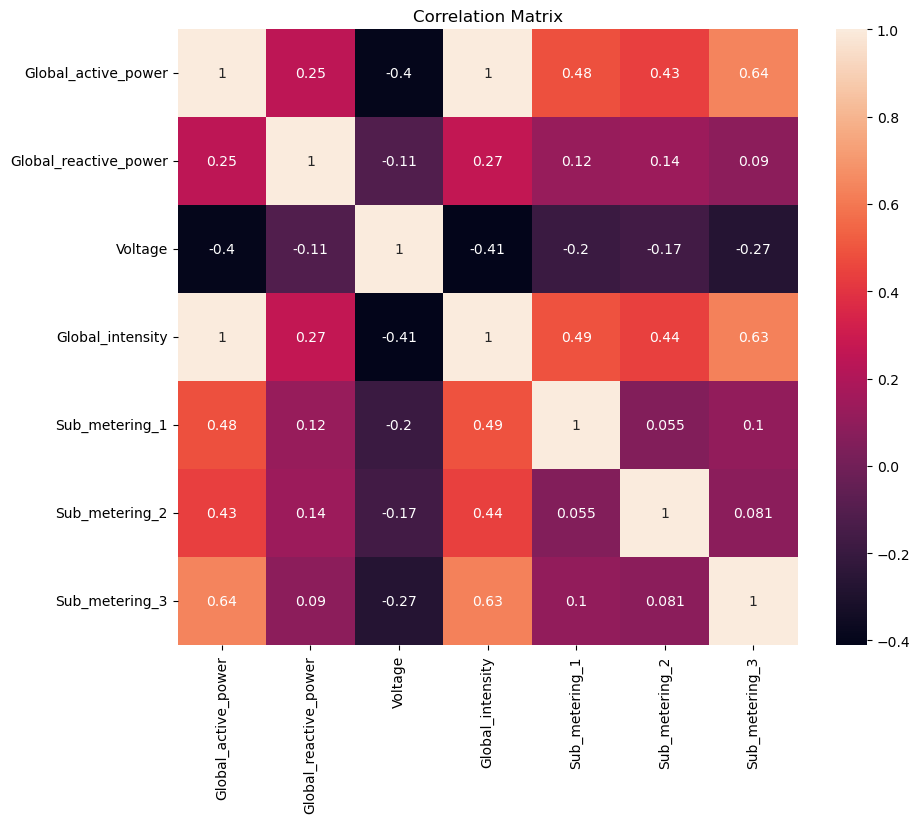

In [6]:
# Ignore date columns
numeric_df = scrubbed.select_dtypes(include=['float64', 'int64'])
print(numeric_df.shape)

# Compute correlation matrix
correlationMatrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlationMatrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

In [7]:
# Global reactive power had the least amount of variance, providing little benefit for modeling purposes

variances = numeric_df.var()
print("Variance Across Each Parameter:")
print(variances)

Variance Across Each Parameter:
Global_active_power       1.117871
Global_reactive_power     0.012706
Voltage                  10.497514
Global_intensity         19.752658
Sub_metering_1           37.859792
Sub_metering_2           33.895992
Sub_metering_3           71.185566
dtype: float64


In [8]:
pickThreshold = VarianceThreshold(threshold=.02)
reduced_df = pickThreshold.fit_transform(numeric_df)
reduced_df.shape

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(reduced_df)

Explained variance ratio for each component:
[5.24922426e-01 1.58018584e-01 1.49501386e-01 1.30415086e-01
 3.69920077e-02 1.50510004e-04]

Cumulative explained variance:
[0.52492243 0.68294101 0.8324424  0.96285748 0.99984949 1.        ]


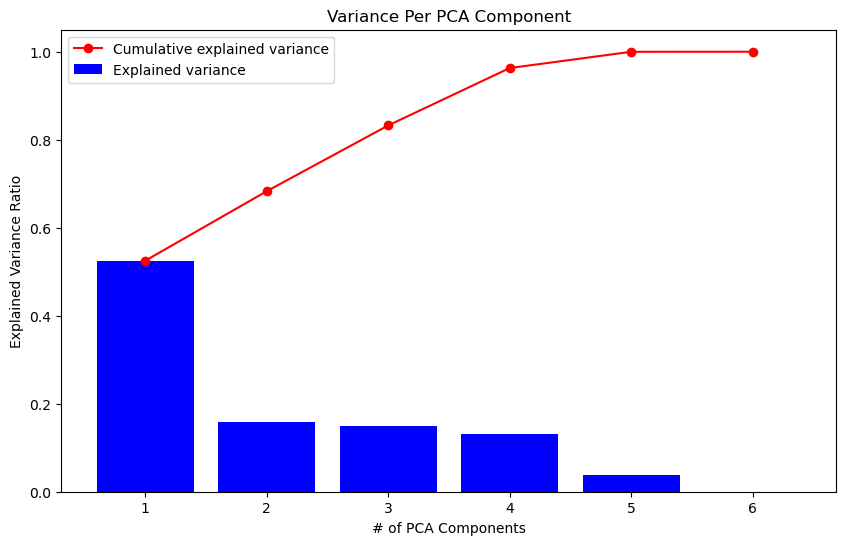

In [9]:
# Implement PCA to start the process of identifying how much variance is captured per component
pca = PCA(n_components=6)
pca.fit(scaled_data)

# Explained variance ratio calculations
print("Explained variance ratio for each component:")
print(pca.explained_variance_ratio_)

# Cumulative explained variance
cumVariance = pca.explained_variance_ratio_.cumsum()
print("\nCumulative explained variance:")
print(cumVariance)

# Explained variance for each component
plt.figure(figsize=(10, 6))
plt.bar(range(1, 7), pca.explained_variance_ratio_, color='blue', label='Explained variance')
plt.plot(range(1, 7), cumVariance, color='red', marker='o', label='Cumulative explained variance')
plt.xlabel('# of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Per PCA Component')
plt.legend()
plt.show()

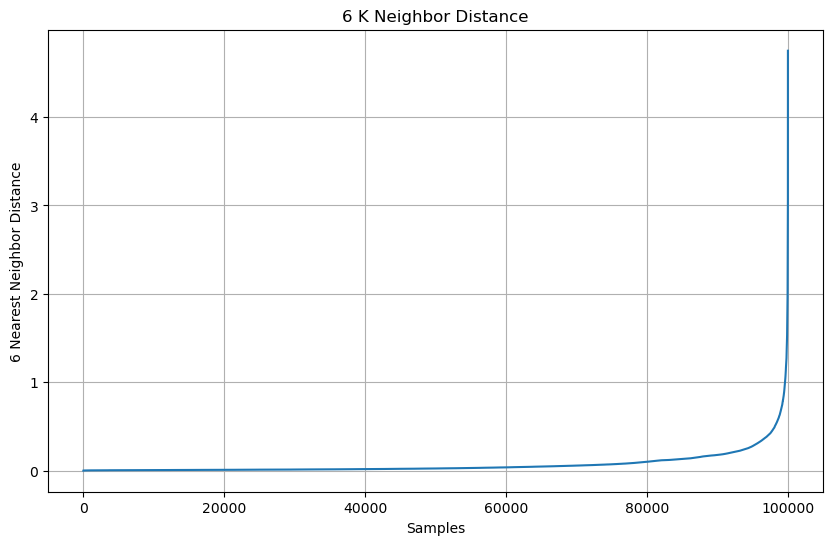

In [10]:
pca = PCA(n_components=5)
pcaData = pca.fit_transform(scaled_data)

# n = 100,000 to account for ~5% of the total dataset
sampled_data = pd.DataFrame(pcaData).sample(n=100000, random_state=0)
k = 6
nn = NearestNeighbors(n_neighbors=k)
nn.fit(sampled_data)

# Calculate distances to k nearest neighbor for each point
distances, indices = nn.kneighbors(sampled_data)

k_distances = np.sort(distances[:, -1])

# k-distance graph, use elbow point in determining DBSCAN eps
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(k_distances) + 1), k_distances)
plt.title('6 K Neighbor Distance')
plt.xlabel('Samples')
plt.ylabel('6 Nearest Neighbor Distance')
plt.grid(True)
plt.show()

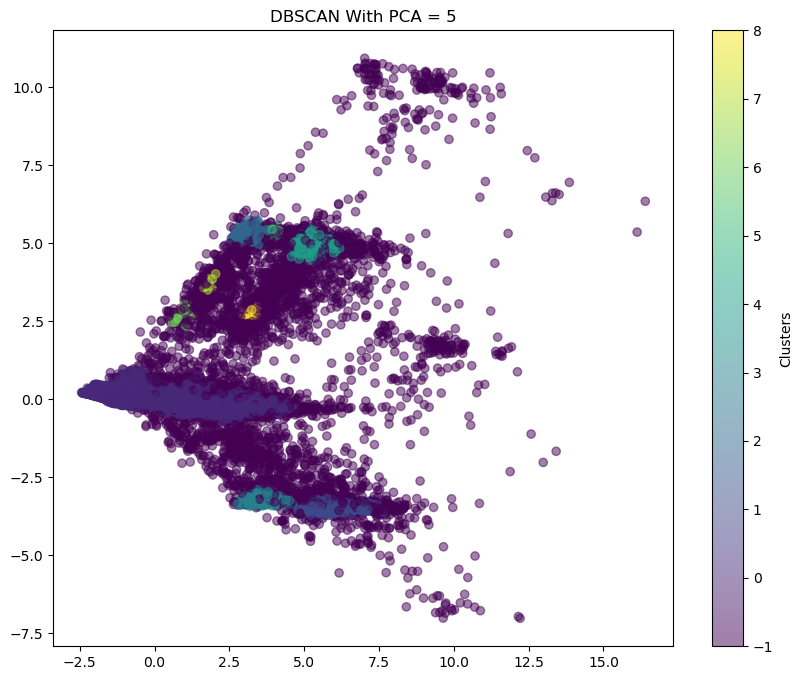

Points per cluster:
 0    93214
-1     4725
 1      927
 3      502
 4      373
 2      167
 6       33
 8       22
 7       19
 5       18
Name: count, dtype: int64


In [11]:
# Applying DBSCAN, altered these values quite a bit with negligible results. This points to the data being unbalanced and DBSCAN not being the best algorithm for this dataset
dbscan = DBSCAN(eps=0.3, min_samples=12)
dbscanLabels = dbscan.fit_predict(sampled_data)

# Visualize the DBSCAN clustering result
plt.figure(figsize=(10, 8))
plt.scatter(sampled_data.iloc[:, 0], sampled_data.iloc[:, 1], c=dbscanLabels, cmap='viridis', alpha=0.5)
plt.title('DBSCAN With PCA = 5')
plt.colorbar(label='Clusters')
plt.show()

# Cluster statistics, quite a bit of noise remains (-1)
print("Points per cluster:")
print(pd.Series(dbscanLabels).value_counts())

In [ ]:
# Score implies okay clustering, but plenty of room for further growth. With the shortcomings of this algorithm, other methods are to be investigated from other group members.
score = silhouette_score(sampled_data, dbscanLabels)
print("Silhouette Score:", score)


Silhouette Score: 0.39221962758270507
